# Project Liseko:: PM10 Prediction in the City of Cape Town

This notebook details the steps taken to predict PM10 in the City of Cape Town. The sections that follow will provide a python code for each of the steps, mainly:

- Data Import & Cleaning
- Data Preparation
- Prediciton Models
<hr>
<b> Gordon Nana Kwesi Amoako </b><br>
<b> DSI, Cape Town </b><br>
<b> 15 October, 2018</b>
<hr>

## Importing libraries needed for the processes to follow


In [1]:
#
# Project LISEKO
# 
# 10 October, 2018
# 

## Read in dataset

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math


from datetime import datetime
from math import sqrt
#from sklearn.ensemble import XGBRegressor
#from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame, Panel


## Import data for cleaning

Two <b>Air Quality</b> datasets for the years <b>2015</b> and <b>2016</b> will be imported for use. Each dataset contains:

- <b> Meteorology data </b>
    - DateTime
    - Wind Direction (Deg)
    - Wind Speed (m/s)
    - Temperature (Deg)
    - Relative Humidity (%)
    - Barometer Pressure (mb)
- <b> PM10 (ug/m3) </b>

The data is collected at vantage points within the city. This is only an initial attempt at developing the air quality prediction model and so only one location, <b>Table view</b>, is used. This was part of an individual project at the DSI and due to time constraints, I only demonstrate how it is done. Data cleaning takes most of the time and I'll get into detail after this project.

In [2]:
## Read in data file
#pm_2015_data = pd.read_csv('2015_tableview_pm10_data.csv', sep=';')
#pm_2015_meteo = pd.read_csv('2015_tableview_meteo_data.csv',sep=';')
#pm_2016_data = pd.read_csv('2016_tableview_pm10_data.csv',sep=';')
#pm_2016_meteo = pd.read_csv('2016_tableview_meteo_data.csv',sep=';')

tableview_pm10_2015_16_data_meteo = pd.read_csv('aq_tableview_15_16_data_full.csv')

In [3]:
## See how the data looks like

tableview_pm10_2015_16_data_meteo.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10
0,2015-01-01 00:00:00,2015,1,153.0,2.4,22.0,74.0,1006.0,26.0
1,2015-01-01 01:00:00,2015,1,142.0,1.1,22.0,76.0,1006.0,34.0
2,2015-01-01 02:00:00,2015,1,44.0,1.5,19.0,82.0,1006.0,38.0
3,2015-01-01 03:00:00,2015,1,2.0,1.9,18.0,85.0,1006.0,69.0
4,2015-01-01 04:00:00,2015,1,55.0,1.7,17.0,88.0,1006.0,26.0


### Add & remove features

- Check dtypes and NaNs
- Add an 'Hour' and 'Month' field

In [4]:
tableview_pm10_2015_16_data_meteo.dtypes

DateTime             object
Year                  int64
Month                 int64
WindDirection       float64
WindSpeed           float64
Temperature         float64
RelativeHumidity    float64
BP                  float64
PM10                float64
dtype: object

In [5]:
## Convert to DateTime 
tableview_pm10_2015_16_data_meteo['DateTime'] = pd.to_datetime(tableview_pm10_2015_16_data_meteo['DateTime'])

## Add 'Hour' feature
tableview_pm10_2015_16_data_meteo['Hour'] = tableview_pm10_2015_16_data_meteo.DateTime.dt.hour

In [6]:
## Make the headers consistent
headLabel = ['DateTime','Year','Month','WindDirection','WindSpeed','Temperature','RelativeHumidity','BP','PM10']

In [7]:
tableview_pm10_2015_16_data_meteo.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10,Hour
0,2015-01-01 00:00:00,2015,1,153.0,2.4,22.0,74.0,1006.0,26.0,0
1,2015-01-01 01:00:00,2015,1,142.0,1.1,22.0,76.0,1006.0,34.0,1
2,2015-01-01 02:00:00,2015,1,44.0,1.5,19.0,82.0,1006.0,38.0,2
3,2015-01-01 03:00:00,2015,1,2.0,1.9,18.0,85.0,1006.0,69.0,3
4,2015-01-01 04:00:00,2015,1,55.0,1.7,17.0,88.0,1006.0,26.0,4


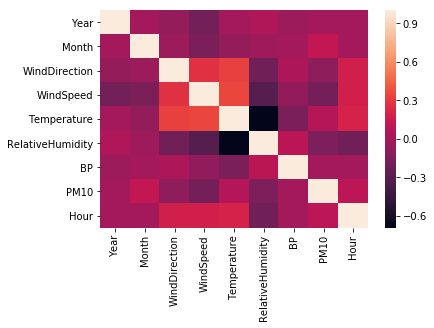

In [8]:
corr = tableview_pm10_2015_16_data_meteo.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [9]:
tableview_pm10_2015_16_data_meteo.describe()

,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10,Hour
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,2015.500684,6.519836,183.292020,3.686799,17.844140,76.069140,1014.723210,26.827348,11.500000
std,0.500014,3.449649,89.613635,1.891702,4.816779,17.698413,19.204545,16.739828,6.922384
min,2015.000000,1.000000,0.000000,0.100000,2.200000,0.000000,503.000000,0.000000,0.000000
25%,2015.000000,4.000000,156.000000,2.100000,14.600000,64.000000,1012.000000,15.000000,5.750000
50%,2016.000000,7.000000,181.000000,3.600000,17.900000,77.000000,1015.000000,24.000000,11.500000
75%,2016.000000,10.000000,251.125000,5.000000,21.000000,91.000000,1018.000000,32.000000,17.250000
max,2016.000000,12.000000,360.000000,12.400000,36.000000,101.000000,1034.000000,215.000000,23.000000


In [10]:
## Some of the columns are object, convert to Numeric

## tableview_pm10_2015_16_data_meteo[['PM10','WindDirection','WindSpeed','Temperature','RelativeHumidity','BP']] = tableview_pm10_2015_16_data_meteo[['PM10','WindDirection','WindSpeed','Temperature','RelativeHumidity','BP']].apply(pd.to_numeric) 

In [11]:
tableview_pm10_2015_16_data_meteo.describe()

,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10,Hour
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,2015.500684,6.519836,183.292020,3.686799,17.844140,76.069140,1014.723210,26.827348,11.500000
std,0.500014,3.449649,89.613635,1.891702,4.816779,17.698413,19.204545,16.739828,6.922384
min,2015.000000,1.000000,0.000000,0.100000,2.200000,0.000000,503.000000,0.000000,0.000000
25%,2015.000000,4.000000,156.000000,2.100000,14.600000,64.000000,1012.000000,15.000000,5.750000
50%,2016.000000,7.000000,181.000000,3.600000,17.900000,77.000000,1015.000000,24.000000,11.500000
75%,2016.000000,10.000000,251.125000,5.000000,21.000000,91.000000,1018.000000,32.000000,17.250000
max,2016.000000,12.000000,360.000000,12.400000,36.000000,101.000000,1034.000000,215.000000,23.000000


In [12]:
tableview_pm10_2015_16_data_meteo.isnull().sum()

DateTime            0
Year                0
Month               0
WindDirection       0
WindSpeed           0
Temperature         0
RelativeHumidity    0
BP                  0
PM10                0
Hour                0
dtype: int64

In [13]:
tableview_pm10_2015_16_data_meteo.dtypes

DateTime            datetime64[ns]
Year                         int64
Month                        int64
WindDirection              float64
WindSpeed                  float64
Temperature                float64
RelativeHumidity           float64
BP                         float64
PM10                       float64
Hour                         int64
dtype: object

## Visualisation & Exploratory Data Analysis (EDA)
Let's do some exploratory data analysis of the data

In [14]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,9]

#### Scatter plot

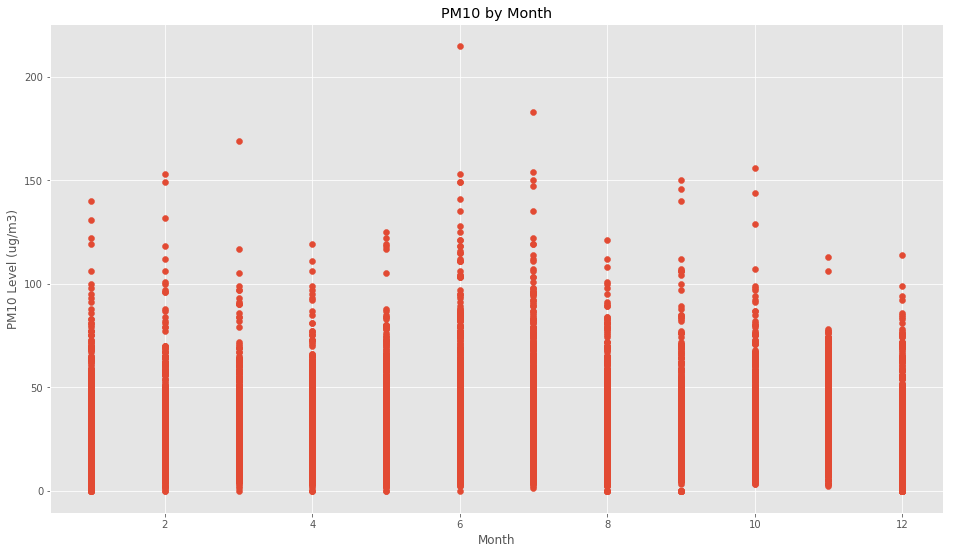

In [15]:
## Scatter plot
X = tableview_pm10_2015_16_data_meteo['Month']
Y =  tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Month')
plt.ylabel('PM10 Level (ug/m3)')
plt.title('PM10 by Month')
plt.show()

Text(0.5,1,'PM10 by Hour')

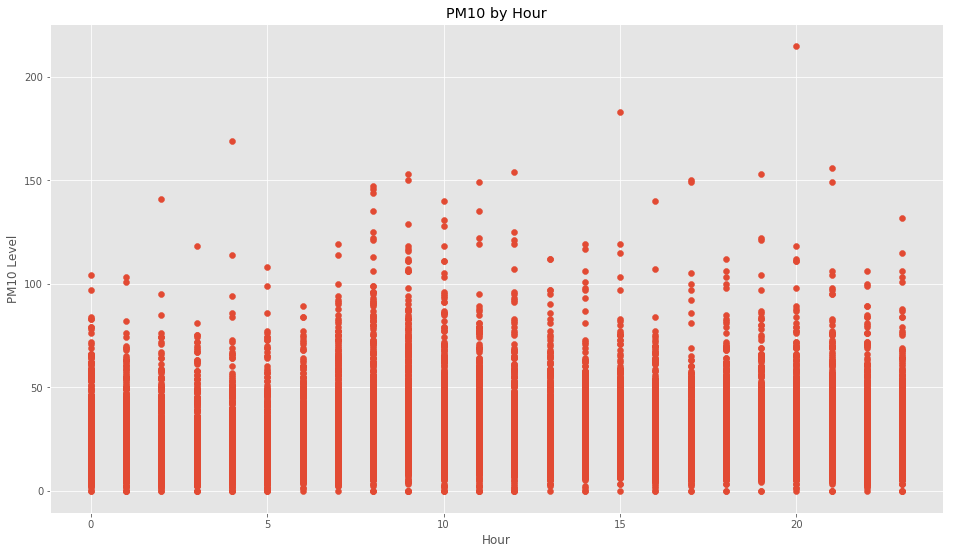

In [16]:
X = tableview_pm10_2015_16_data_meteo['Hour']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Hour')
plt.ylabel('PM10 Level')
plt.title('PM10 by Hour')

Text(0.5,1,'PM10 by Windspeed')

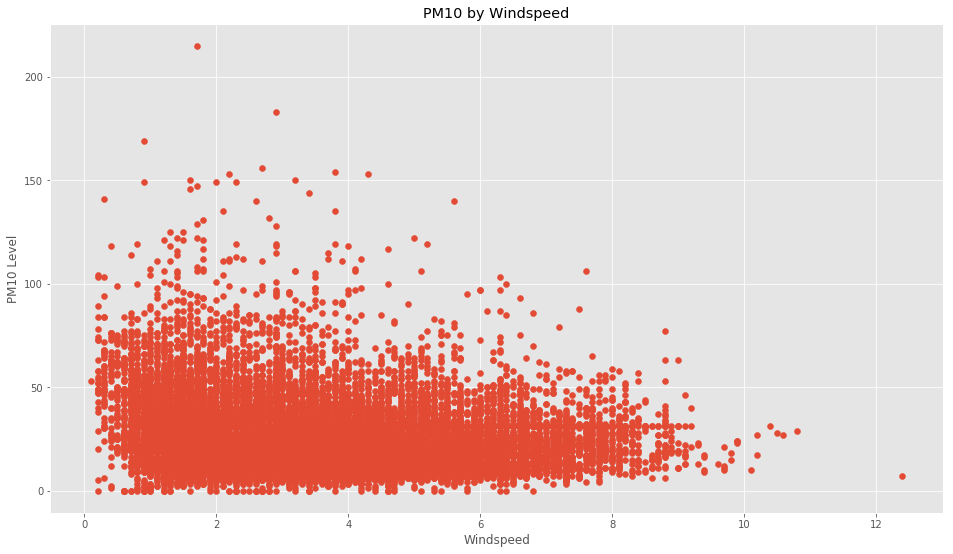

In [17]:
X = tableview_pm10_2015_16_data_meteo['WindSpeed']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Windspeed')
plt.ylabel('PM10 Level')
plt.title('PM10 by Windspeed')

Text(0.5,1,'PM10 by Wind Direction')

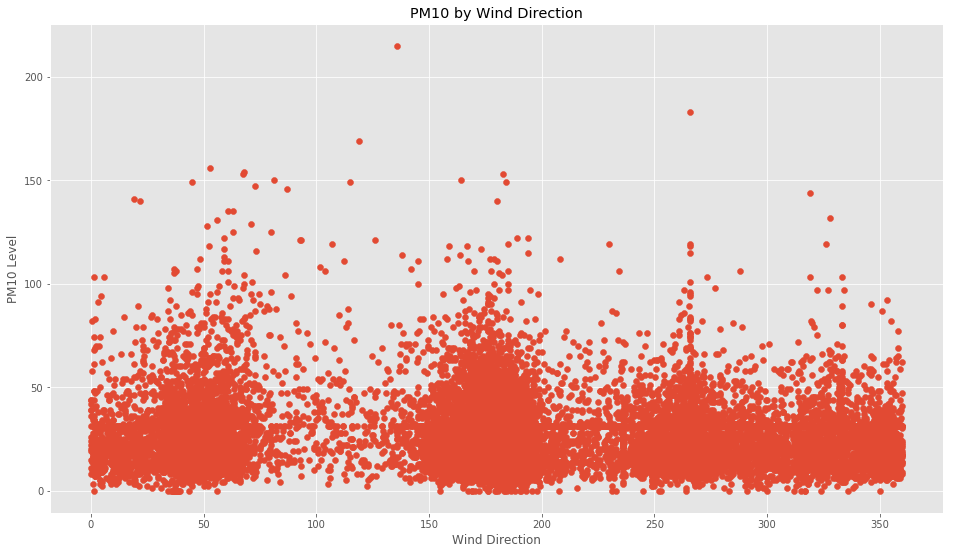

In [18]:
X = tableview_pm10_2015_16_data_meteo['WindDirection']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Wind Direction')
plt.ylabel('PM10 Level')
plt.title('PM10 by Wind Direction')

Text(0.5,1,'PM10 by Barometer Pressure')

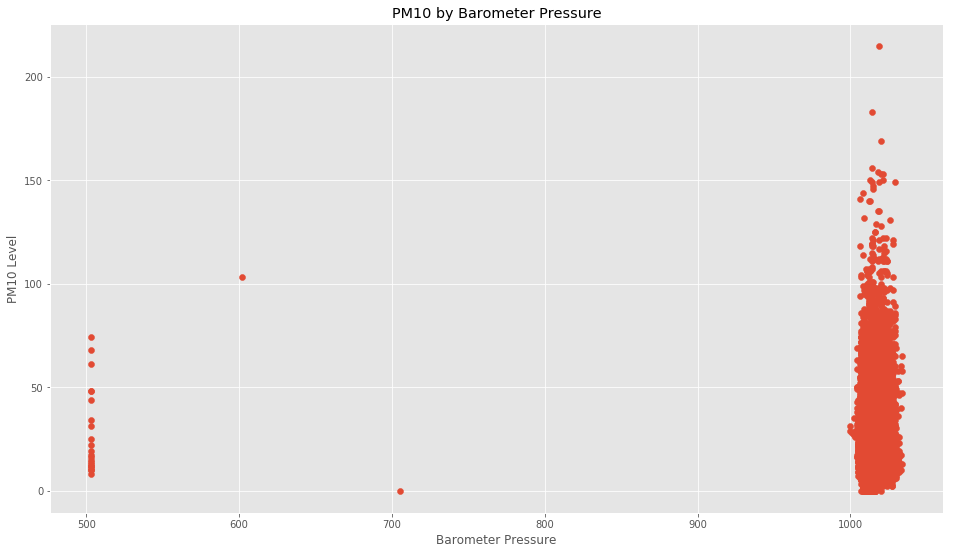

In [19]:
X = tableview_pm10_2015_16_data_meteo['BP']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Barometer Pressure')
plt.ylabel('PM10 Level')
plt.title('PM10 by Barometer Pressure')

Text(0.5,1,'PM10 by Relative Humidity')

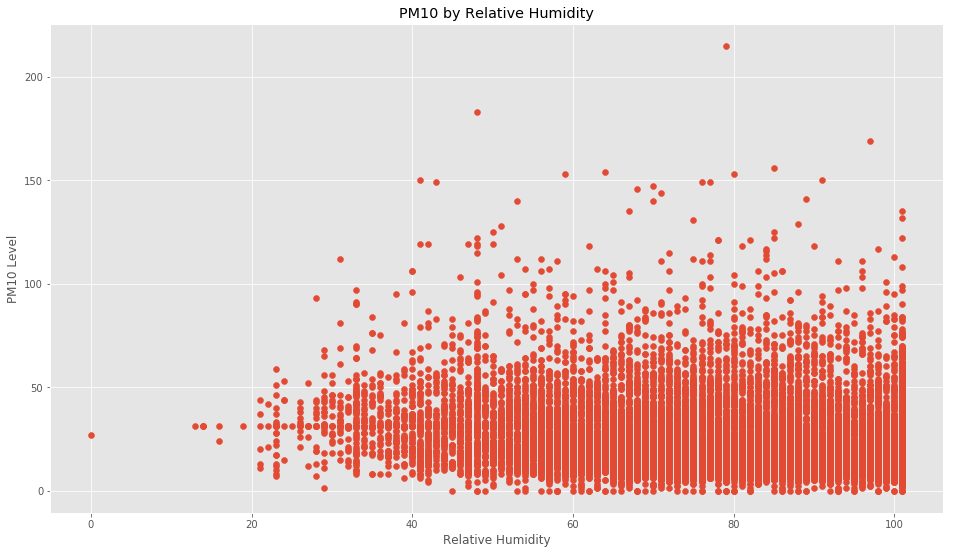

In [20]:
X = tableview_pm10_2015_16_data_meteo['RelativeHumidity']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Relative Humidity')
plt.ylabel('PM10 Level')
plt.title('PM10 by Relative Humidity')

Text(0.5,1,'PM10 by Temperature')

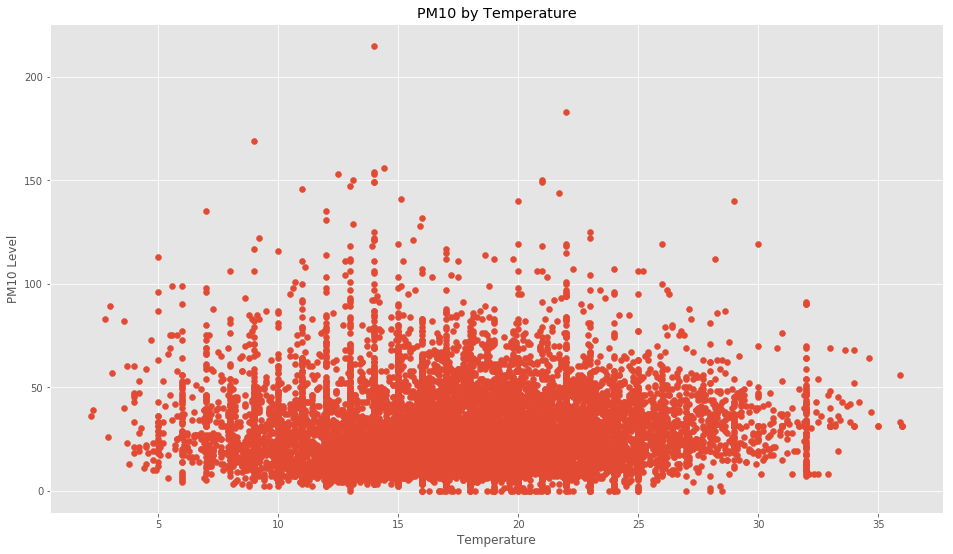

In [21]:
X = tableview_pm10_2015_16_data_meteo['Temperature']
Y = tableview_pm10_2015_16_data_meteo['PM10']
plt.scatter(X,Y)
plt.xlabel('Temperature')
plt.ylabel('PM10 Level')
plt.title('PM10 by Temperature')

In [22]:
def plotTimeSeries(start,end):
    
    time_series_df = tableview_pm10_2015_16_data_meteo[['DateTime', 'PM10']][(tableview_pm10_2015_16_data_meteo['DateTime'] >= start) & (tableview_pm10_2015_16_data_meteo['DateTime'] <= end)]
    X = time_series_df.DateTime
    Y = time_series_df.PM10
    plt.plot(X,Y)
    plt.xlabel('Time')
    plt.ylabel('PM10 Value')
    plt.title('PM10 Time Series')
    return plt.show();

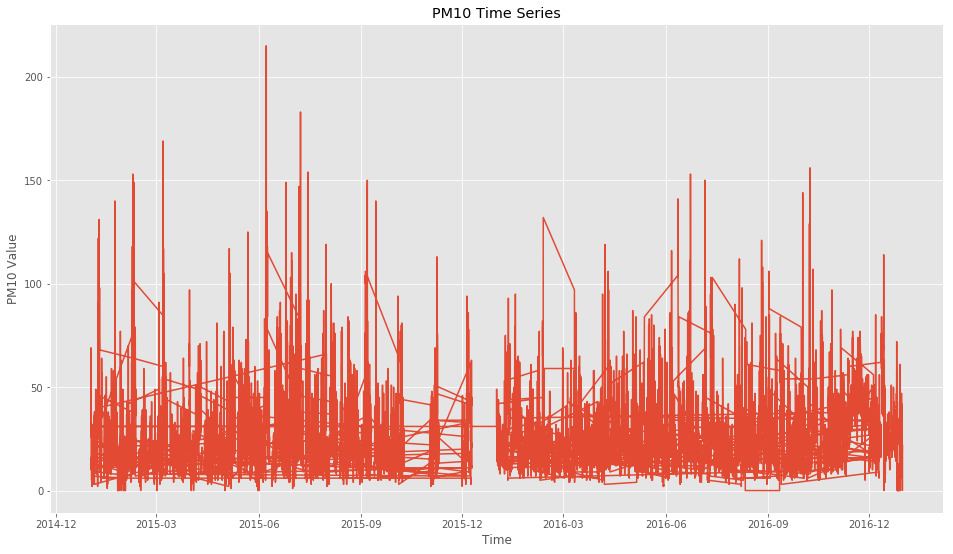

In [23]:
plotTimeSeries('2015-01-01','2016-12-31')

### Feature Engineering of Time Series Data:: Rolling Windows & Shifts for the Timeseries Data
Apply a rolling window and shift to the time series data here. The following URLs provide excellent resources:

https://medium.com/making-sense-of-data/time-series-next-value-prediction-using-regression-over-a-rolling-window-228f0acae363

http://www.early-warning-signals.org/time-series-methods/metric-based-indicators/general-steps-for-rolling-window-metrics/


In [24]:
## Rolling window function

def RollingWindows(labels,df):  
    import pandas as pd
    #fullLabel = []
    shifted_df = pd.DataFrame()
    
    for i in range(1,len(labels) + 3):
        for feature in labels:
            colLabel = feature + '_{}'.format(i)
            shifted_df[colLabel] = df[feature].shift(periods = i) # Create the list of headers here
    return shifted_df

In [25]:
## Make the base labels ready for the features engineering

baseLabels = ['WindDirection','WindSpeed','Temperature','RelativeHumidity','PM10']

columnLabels = ['DateTime','Year','Month','Hour','WindDirection','WindSpeed','Temperature','RelativeHumidity','BP','PM10']

In [26]:
## Create a new dataframe with the features from rolling windows and shift
tableview_pm10_15_16_full = pd.concat([tableview_pm10_2015_16_data_meteo,RollingWindows(baseLabels,tableview_pm10_2015_16_data_meteo)], axis=1)

In [27]:
tableview_pm10_15_16_full.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10,Hour,...,WindDirection_6,WindSpeed_6,Temperature_6,RelativeHumidity_6,PM10_6,WindDirection_7,WindSpeed_7,Temperature_7,RelativeHumidity_7,PM10_7
0,2015-01-01 00:00:00,2015,1,153.0,2.4,22.0,74.0,1006.0,26.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 01:00:00,2015,1,142.0,1.1,22.0,76.0,1006.0,34.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 02:00:00,2015,1,44.0,1.5,19.0,82.0,1006.0,38.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 03:00:00,2015,1,2.0,1.9,18.0,85.0,1006.0,69.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 04:00:00,2015,1,55.0,1.7,17.0,88.0,1006.0,26.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
## Forward & Backward fill method for the NaNs
tableview_pm10_15_16_full  = tableview_pm10_15_16_full.bfill()

In [29]:
tableview_pm10_15_16_full.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,BP,PM10,Hour,...,WindDirection_6,WindSpeed_6,Temperature_6,RelativeHumidity_6,PM10_6,WindDirection_7,WindSpeed_7,Temperature_7,RelativeHumidity_7,PM10_7
0,2015-01-01 00:00:00,2015,1,153.0,2.4,22.0,74.0,1006.0,26.0,0,...,153.0,2.4,22.0,74.0,26.0,153.0,2.4,22.0,74.0,26.0
1,2015-01-01 01:00:00,2015,1,142.0,1.1,22.0,76.0,1006.0,34.0,1,...,153.0,2.4,22.0,74.0,26.0,153.0,2.4,22.0,74.0,26.0
2,2015-01-01 02:00:00,2015,1,44.0,1.5,19.0,82.0,1006.0,38.0,2,...,153.0,2.4,22.0,74.0,26.0,153.0,2.4,22.0,74.0,26.0
3,2015-01-01 03:00:00,2015,1,2.0,1.9,18.0,85.0,1006.0,69.0,3,...,153.0,2.4,22.0,74.0,26.0,153.0,2.4,22.0,74.0,26.0
4,2015-01-01 04:00:00,2015,1,55.0,1.7,17.0,88.0,1006.0,26.0,4,...,153.0,2.4,22.0,74.0,26.0,153.0,2.4,22.0,74.0,26.0


In [30]:
tableview_pm10_15_16_full = tableview_pm10_15_16_full.drop(['BP'],axis=1)

In [31]:
tableview_pm10_15_16_full.describe()

,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,PM10,Hour,WindDirection_1,WindSpeed_1,...,WindDirection_6,WindSpeed_6,Temperature_6,RelativeHumidity_6,PM10_6,WindDirection_7,WindSpeed_7,Temperature_7,RelativeHumidity_7,PM10_7
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,...,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,2015.500684,6.519836,183.292020,3.686799,17.844140,76.069140,26.827348,11.500000,183.290424,3.686873,...,183.283635,3.687255,17.843810,76.066860,26.831224,183.282353,3.687329,17.843508,76.068057,26.832478
std,0.500014,3.449649,89.613635,1.891702,4.816779,17.698413,16.739828,6.922384,89.613925,1.891626,...,89.615304,1.891230,4.816386,17.697221,16.737811,89.615577,1.891155,4.815959,17.696371,16.736925
min,2015.000000,1.000000,0.000000,0.100000,2.200000,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.100000,2.200000,0.000000,0.000000,0.000000,0.100000,2.200000,0.000000,0.000000
25%,2015.000000,4.000000,156.000000,2.100000,14.600000,64.000000,15.000000,5.750000,156.000000,2.100000,...,156.000000,2.100000,14.600000,64.000000,15.000000,156.000000,2.100000,14.600000,64.000000,15.000000
50%,2016.000000,7.000000,181.000000,3.600000,17.900000,77.000000,24.000000,11.500000,181.000000,3.600000,...,181.000000,3.600000,17.900000,77.000000,24.000000,181.000000,3.600000,17.900000,77.000000,24.000000
75%,2016.000000,10.000000,251.125000,5.000000,21.000000,91.000000,32.000000,17.250000,251.125000,5.000000,...,251.125000,5.000000,21.000000,91.000000,32.000000,251.125000,5.000000,21.000000,91.000000,32.000000
max,2016.000000,12.000000,360.000000,12.400000,36.000000,101.000000,215.000000,23.000000,360.000000,12.400000,...,360.000000,12.400000,36.000000,101.000000,215.000000,360.000000,12.400000,36.000000,101.000000,215.000000


#### Visualise the final cleaned data

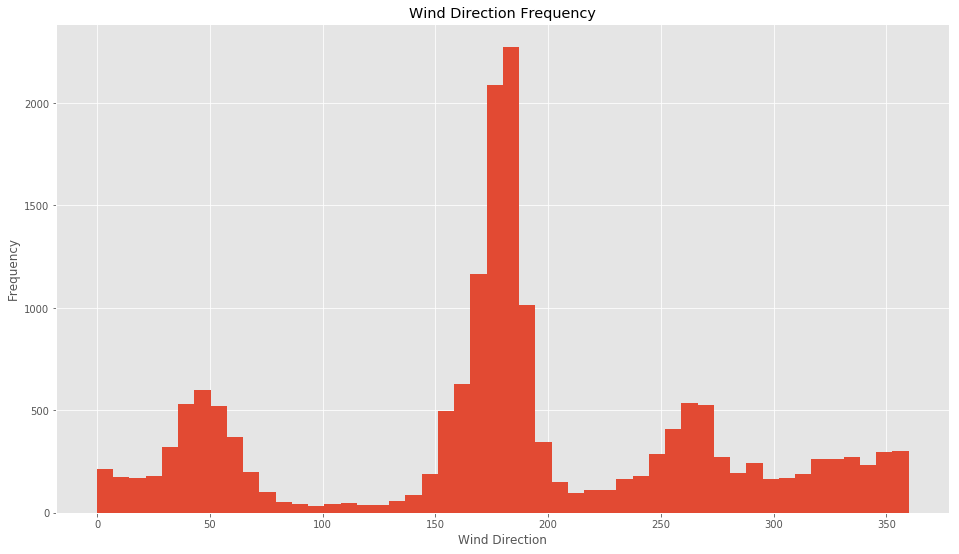

In [32]:
## Some more visualisation

plt.hist(tableview_pm10_15_16_full.WindDirection[(tableview_pm10_15_16_full.WindDirection < 360) & (tableview_pm10_15_16_full.PM10 >= .2)], 50)
plt.xlabel('Wind Direction')
plt.ylabel('Frequency')
plt.title('Wind Direction Frequency')
plt.show()

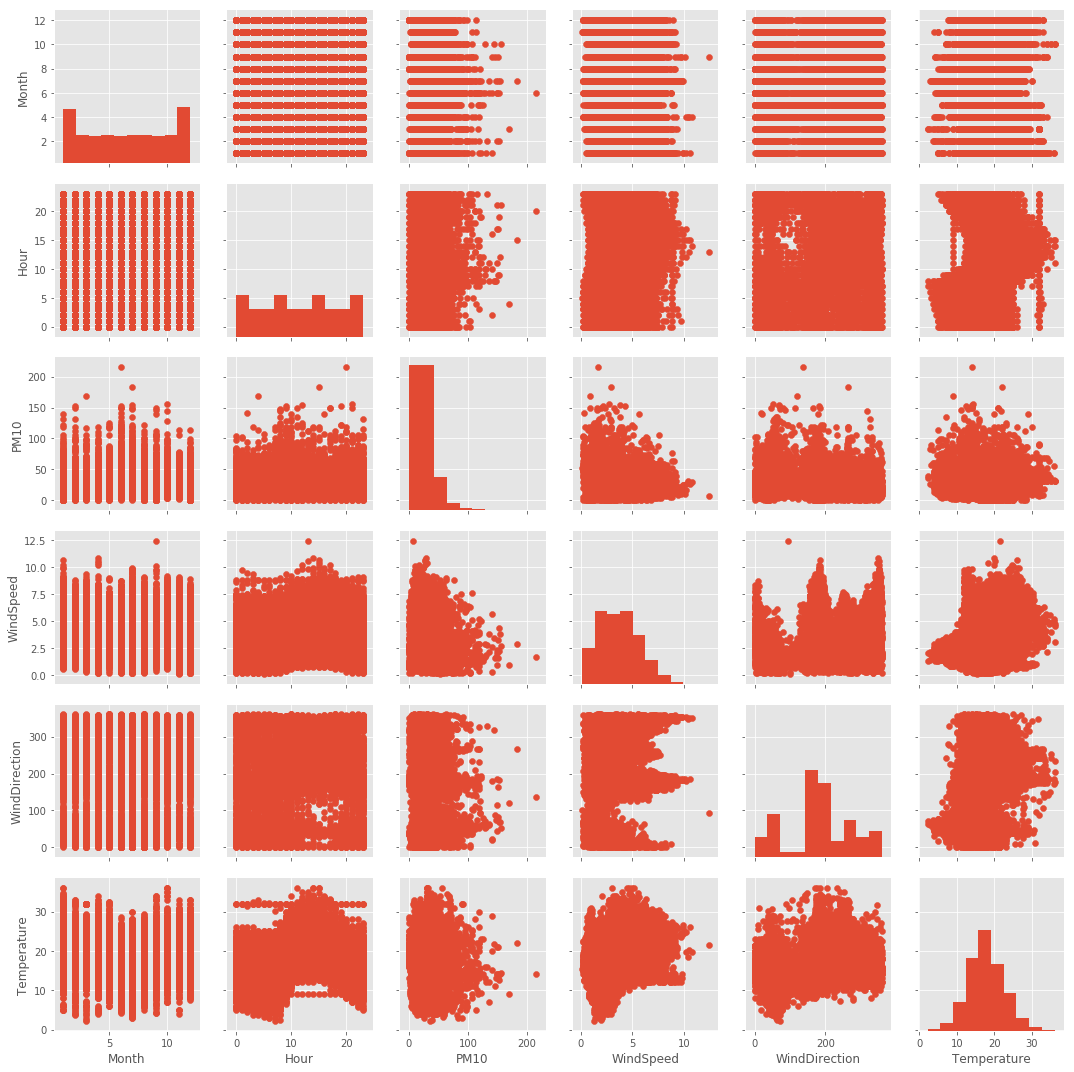

In [33]:
grid = sns.PairGrid(tableview_pm10_15_16_full, vars=['Month', 'Hour', 'PM10','WindSpeed','WindDirection','Temperature'],dropna=True)
grid.map_diag(plt.hist)
grid.map_offdiag(plt.scatter);

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

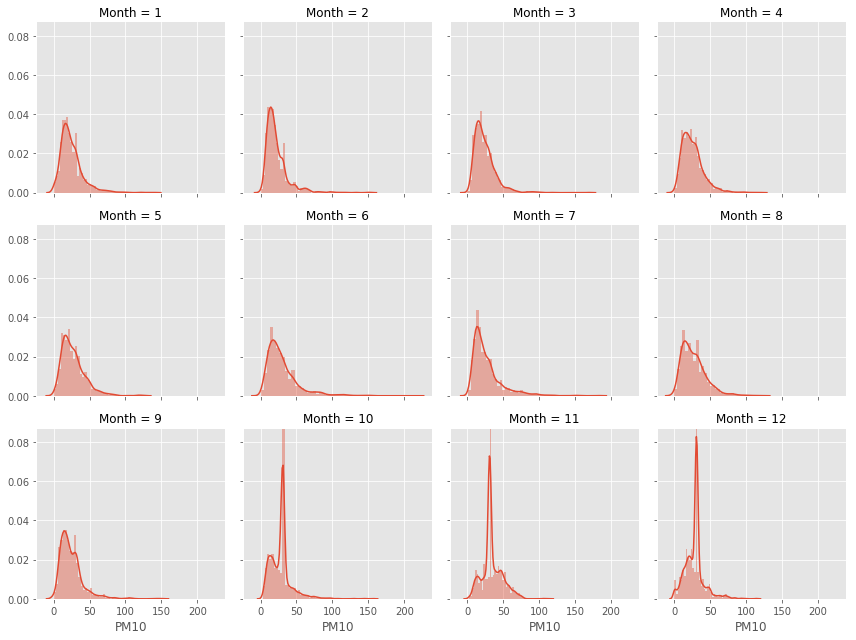

In [34]:
grid = sns.FacetGrid(tableview_pm10_15_16_full, col="Month", col_wrap=4)
grid.map(sns.distplot, "PM10")
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

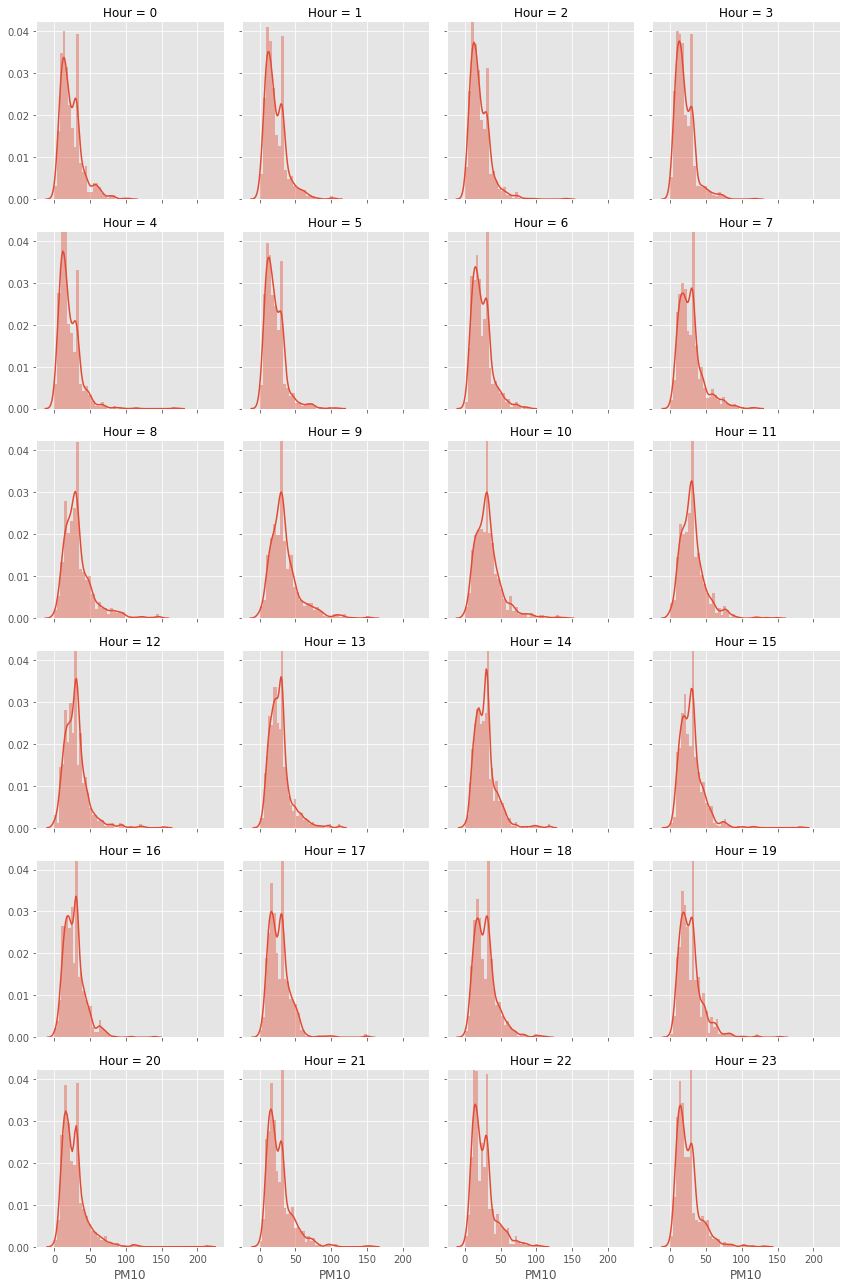

In [35]:
grid = sns.FacetGrid(tableview_pm10_15_16_full, col="Hour", col_wrap=4)
grid.map(sns.distplot, "PM10")
plt.show()

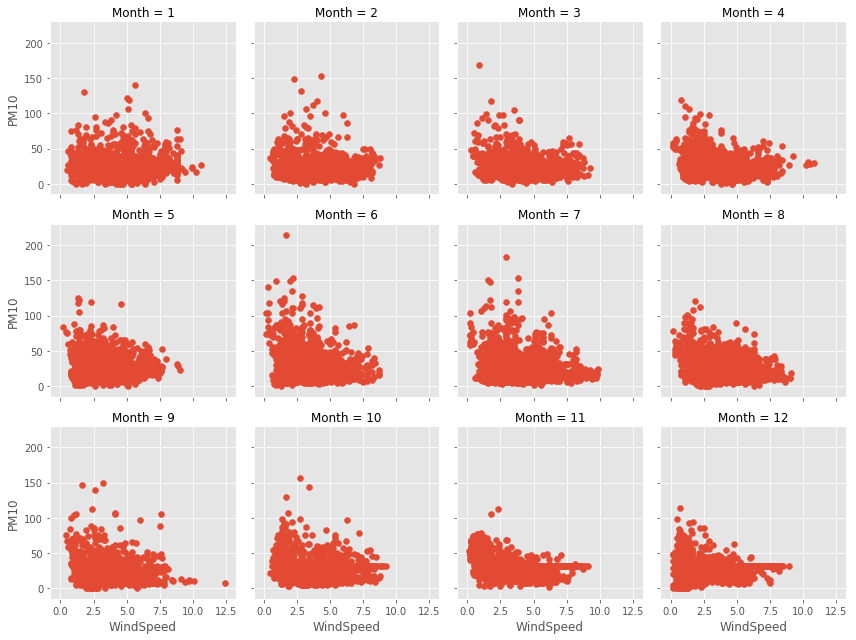

In [36]:
grid = sns.FacetGrid(tableview_pm10_15_16_full, col="Month", col_wrap=4)
grid.map(plt.scatter,"WindSpeed","PM10")
plt.show()

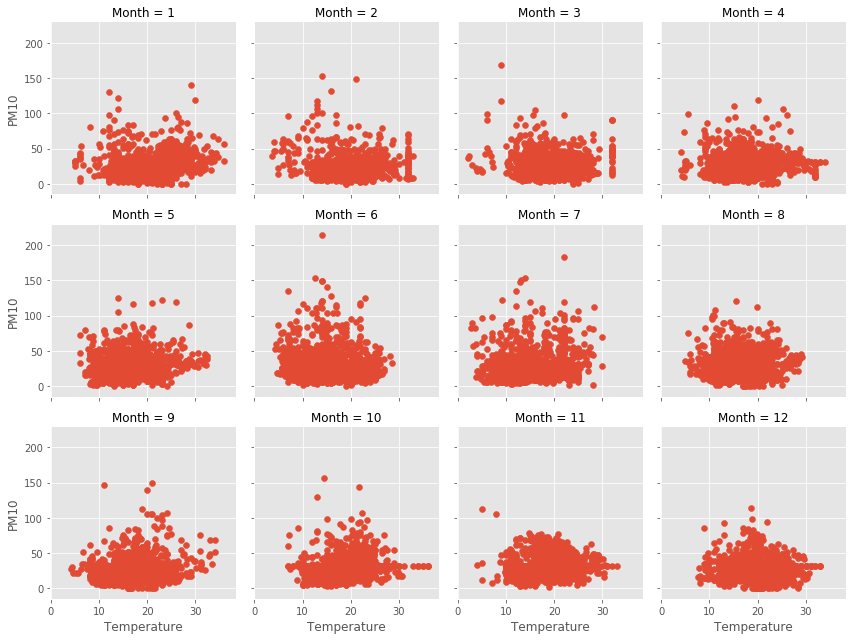

In [37]:
grid = sns.FacetGrid(tableview_pm10_15_16_full, col="Month", col_wrap=4)
grid.map(plt.scatter,"Temperature","PM10")
plt.show()

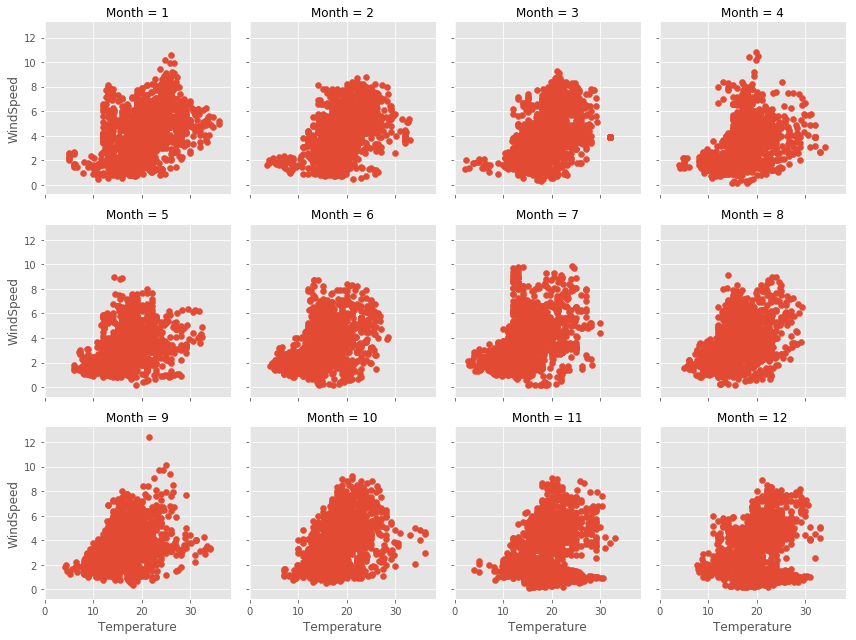

In [38]:
grid = sns.FacetGrid(tableview_pm10_15_16_full, col="Month", col_wrap=4)
grid.map(plt.scatter,"Temperature","WindSpeed")
plt.show()

#### Violin Plots

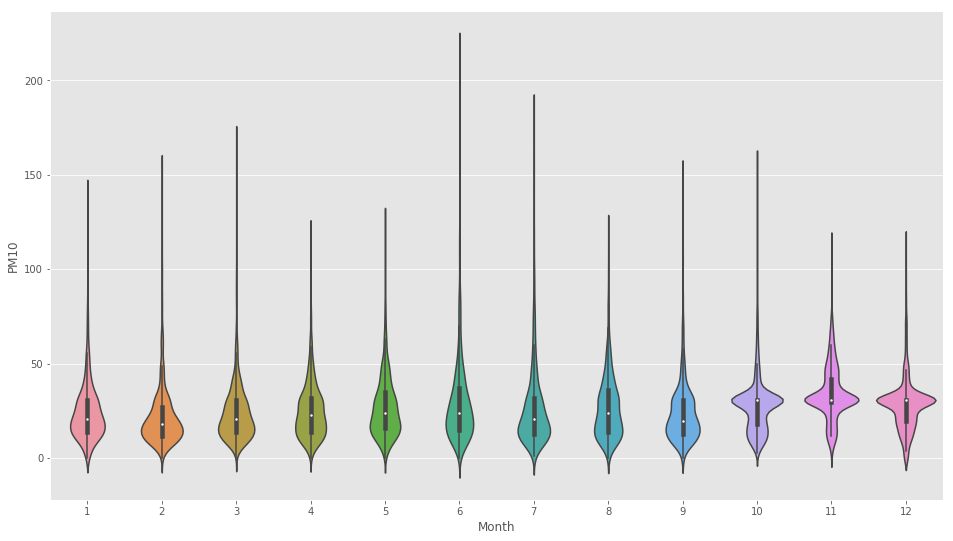

In [39]:
ax = sns.violinplot(x='Month', y='PM10', data=tableview_pm10_15_16_full)

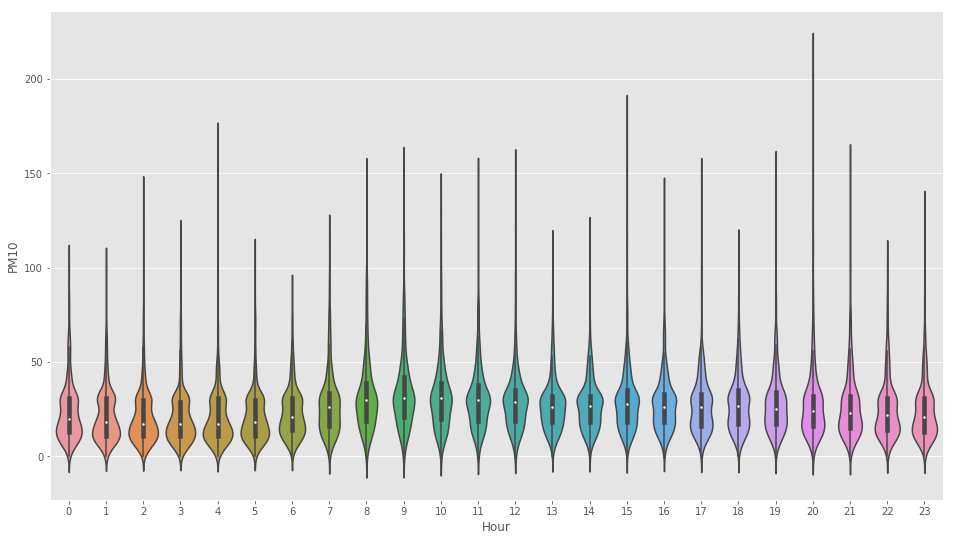

In [40]:
ax = sns.violinplot(x='Hour', y='PM10', data=tableview_pm10_15_16_full)

#### Correlation Plot

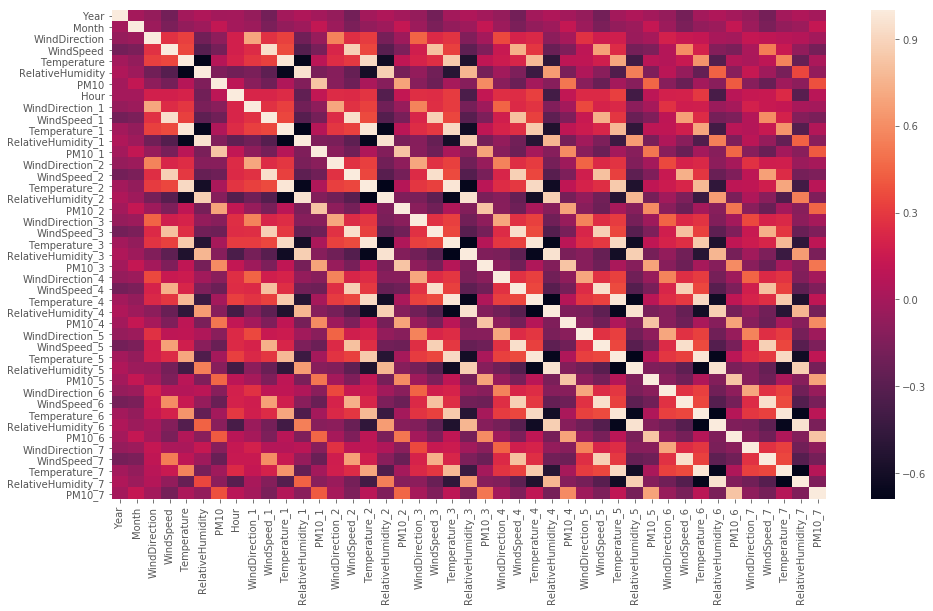

In [41]:
corr = tableview_pm10_15_16_full.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#### Hour & Month cyclic features feature engineering
From David Kaleko
http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [42]:
#tableview_pm10_15_16_full['HourSin'] = np.sin(tableview_pm10_15_16_full.Hour*(2.*np.pi/24))
#tableview_pm10_15_16_full['HourCos'] = np.cos(tableview_pm10_15_16_full.Hour*(2.*np.pi/24))
#tableview_pm10_15_16_full['MonthSin'] = np.sin((tableview_pm10_15_16_full.Month-1)*(2.*np.pi/12))
#tableview_pm10_15_16_full['MonthCos'] = np.cos((tableview_pm10_15_16_full.Month-1)*(2.*np.pi/12))

Visualise the created features

In [43]:
#tableview_pm10_15_16_full.plot.scatter('HourSin','HourCos').set_aspect('equal')
#tableview_pm10_15_16_full.plot.scatter('MonthSin','MonthCos').set_aspect('equal')
#plt.show()

In [44]:
tableview_pm10_15_16_full.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['DateTime', 'Year', 'Month', 'WindDirection', 'WindSpeed',
       'Temperature', 'RelativeHumidity', 'PM10', 'Hour', 'WindDirection_1',
       'WindSpeed_1', 'Temperature_1', 'RelativeHumidity_1', 'PM10_1',
       'WindDirection_2', 'WindSpeed_2', 'Temperature_2', 'RelativeHumidity_2',
       'PM10_2', 'WindDirection_3', 'WindSpeed_3', 'Temperature_3',
       'RelativeHumidity_3', 'PM10_3', 'WindDirection_4', 'WindSpeed_4',
       'Temperature_4', 'RelativeHumidity_4', 'PM10_4', 'WindDirection_5',
       'WindSpeed_5', 'Temperature_5', 'RelativeHumidity_5', 'PM10_5',
       'WindDirection_6', 'WindSpeed_6', 'Temperature_6', 'RelativeHumidity_6',
       'PM10_6', 'WindDirection_7', 'WindSpeed_7', 'Temperature_7',
       'RelativeHumidity_7', 'PM10_7'],
      dtype='object')>

#### Convert Wind Speed from m/s to Km/h

1 m/s = 3.6 km/h

In [45]:
tableview_pm10_15_16_full[['WindSpeed','WindSpeed_1','WindSpeed_2','WindSpeed_3','WindSpeed_4','WindSpeed_5','WindSpeed_6','WindSpeed_7']] = tableview_pm10_15_16_full[['WindSpeed','WindSpeed_1','WindSpeed_2','WindSpeed_3','WindSpeed_4','WindSpeed_5','WindSpeed_6','WindSpeed_7']]*3.6

#### Create Day of Week & Day of Week Category Feature
Get the day of the week and create categories

In [46]:
## Day of Week
tableview_pm10_15_16_full['DayofWeek'] = tableview_pm10_15_16_full['DateTime'].dt.weekday_name

## Day of Week Category
#tableview_pm10_15_16_full['DayofWeekCat'] = tableview_pm10_15_16_full.DayofWeek.astype('category').cat.codes

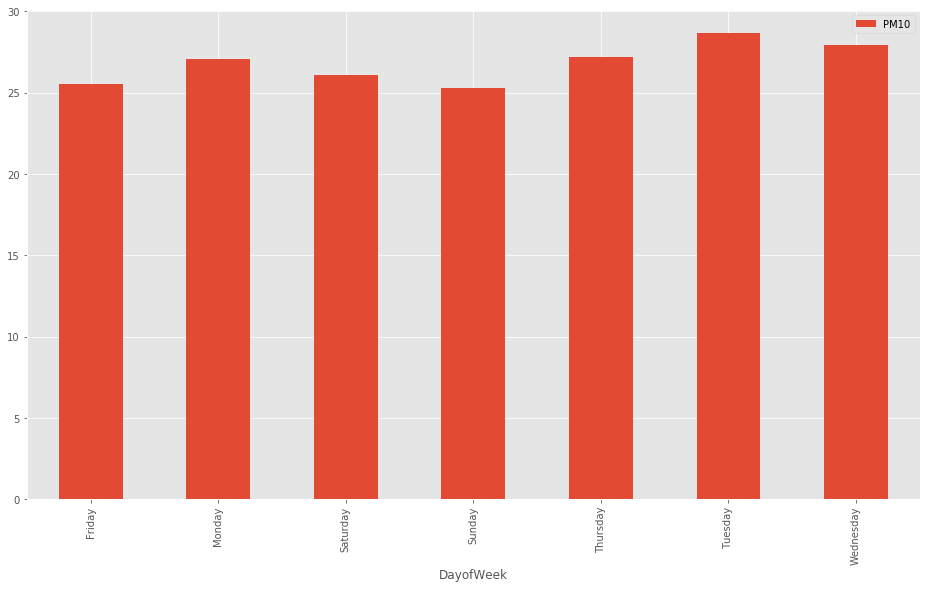

In [47]:
## Some plots
ld = tableview_pm10_15_16_full[['PM10','DayofWeek']].groupby(['DayofWeek']).mean()
ld.plot(kind='bar')

In [48]:
## Drop the Day of Week feature
#tableview_pm10_15_16_full = tableview_pm10_15_16_full.drop(labels='DayofWeek',axis=1)

In [49]:
tableview_pm10_15_16_full.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,PM10,Hour,WindDirection_1,...,WindSpeed_6,Temperature_6,RelativeHumidity_6,PM10_6,WindDirection_7,WindSpeed_7,Temperature_7,RelativeHumidity_7,PM10_7,DayofWeek
0,2015-01-01 00:00:00,2015,1,153.0,8.64,22.0,74.0,26.0,0,153.0,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
1,2015-01-01 01:00:00,2015,1,142.0,3.96,22.0,76.0,34.0,1,153.0,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
2,2015-01-01 02:00:00,2015,1,44.0,5.40,19.0,82.0,38.0,2,142.0,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
3,2015-01-01 03:00:00,2015,1,2.0,6.84,18.0,85.0,69.0,3,44.0,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
4,2015-01-01 04:00:00,2015,1,55.0,6.12,17.0,88.0,26.0,4,2.0,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday


## PM10 Prediction Model

#### Split into Training and Test Datasets

The data will be split into Training and Test Data. Also I will have X and Y variables to give meaning to what is being predicted. In the case of this study, the PM10 values are being predicted


In [50]:
Y = tableview_pm10_15_16_full['PM10']
X = tableview_pm10_15_16_full.drop(['PM10'], axis=1)

In [51]:
X.head(5)

,DateTime,Year,Month,WindDirection,WindSpeed,Temperature,RelativeHumidity,Hour,WindDirection_1,WindSpeed_1,...,WindSpeed_6,Temperature_6,RelativeHumidity_6,PM10_6,WindDirection_7,WindSpeed_7,Temperature_7,RelativeHumidity_7,PM10_7,DayofWeek
0,2015-01-01 00:00:00,2015,1,153.0,8.64,22.0,74.0,0,153.0,8.64,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
1,2015-01-01 01:00:00,2015,1,142.0,3.96,22.0,76.0,1,153.0,8.64,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
2,2015-01-01 02:00:00,2015,1,44.0,5.40,19.0,82.0,2,142.0,3.96,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
3,2015-01-01 03:00:00,2015,1,2.0,6.84,18.0,85.0,3,44.0,5.40,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday
4,2015-01-01 04:00:00,2015,1,55.0,6.12,17.0,88.0,4,2.0,6.84,...,8.64,22.0,74.0,26.0,153.0,8.64,22.0,74.0,26.0,Thursday


#### One-hot Encoding (OHE)
OHE of 'Month' & 'Hour'

In [52]:
## One-hot encoding

## One-hot encoding for Hour & Month
hour_OHE = pd.get_dummies(X['Hour'],prefix='Hour')
month_OHE = pd.get_dummies(X['Month'],prefix='Month') 
dayofweek_OHE = pd.get_dummies(X['DayofWeek'],prefix='DayofWeek') 

## Concatenate
X = pd.concat([X,hour_OHE, month_OHE,dayofweek_OHE], axis=1)

X = X.drop(['Hour_0','Month_1','DayofWeek','DayofWeek_Sunday','Hour','Month','DateTime','Year'],axis=1) # Dimensionality Reduction

In [53]:
#X['WindSpeedWeight'] = np.where(X['WindDirection']<2,1,0)

#highWindSpeed = tableview_pm10_15_16_full_2.loc[tableview_pm10_15_16_full_2['WindSpeed']>=2,['PM10']].mean()
#lowWindSpeed = tableview_pm10_15_16_full_2.loc[tableview_pm10_15_16_full_2['WindSpeed']<2,['PM10']].mean()

#print(lowWindSpeed,highWindSpeed)

# Create a new column based on the windspeed

#X['WindSpeedWeight'] = np.where(X['WindDirection']<2,1,0)

In [54]:
#X = X.drop(['BP','BP_1','BP_2','BP_3','BP_4','BP_5','BP_6','BP_7','BP_8','BP_9','BP_10'],axis=1)

In [55]:
## Commence splitting here

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=.35, random_state=1234)

In [56]:
X_Train.shape, Y_Train.shape

((11403, 79), (11403,))

In [57]:
#X = X.drop(['DayofWeek'],axis=1)

#### RMSE, MAE and R^2 Values
Functions to calculate the
- Root Mean Squared Error
- Mean Absolute Error
- R^2

In [58]:
def ModelErrors(y_test,y_predict):
    ##
    ## RMSE, MAE and R^2
    rmse = mean_squared_error(y_test,y_predict)
    mae = mean_absolute_error(y_test,y_predict)
    r2 = r2_score(y_test,y_predict)
    
    ## Send to CreateGrid()
    CreateGrid([rmse,mae,r2])

In [59]:
def CreateGrid(value_vec):
    ## Just give me some nice output
    ## value_vec = [RMSE, MAE, ModelScore] in that order
    print('-'*49)
    print('|\t'+'RMSE\t|'+'\tMAE\t|'+'\tR^2\t|')
    print('-'*49 + '\n')
    print('|\t{:.3}\t|\t{:.3}\t|\t{:.3}\t|'.format(value_vec[0],value_vec[1],value_vec[2]))
    print('-'*49)

#### Visualisation Function

In [60]:
def VisualiseModel(y_test,y_pred,titl):
    ##
    ##
    plt.scatter(y_test, y_pred)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(titl)
    plt.show()

# Implementing the Machine Learning Algorithms 

The model prediction will be done here. I am going to implement a number of ML algorithms for prediciton of Particulate Matter (PM10).


- Linear Regression
- Multi-Layer Perceptron Regression
- Neural Networks*

#### Linear Regression Model

In [61]:
def LRModel(x_train,y_train,x_test,y_test):
    ## x - x_train
    ## y - y_train
    # Create linear regression object
    aqModelLR = LinearRegression()
    # Train model
    aqModelLR.fit(x_train,y_train)
    # Prediction w/ the test set
    aqPredict = aqModelLR.predict(x_test)
    aqModelScore = aqModelLR.score(x_test,y_test)
    
    ModelErrors(y_test,aqPredict)
    
    ## Visualise
    title = 'Linear Regression Predicted vs Actual'
    VisualiseModel(y_test, aqPredict, title)
    
    return aqPredict,aqModelScore

-------------------------------------------------
|	RMSE	|	MAE	|	R^2	|
-------------------------------------------------

|	80.2	|	5.6	|	0.71	|
-------------------------------------------------


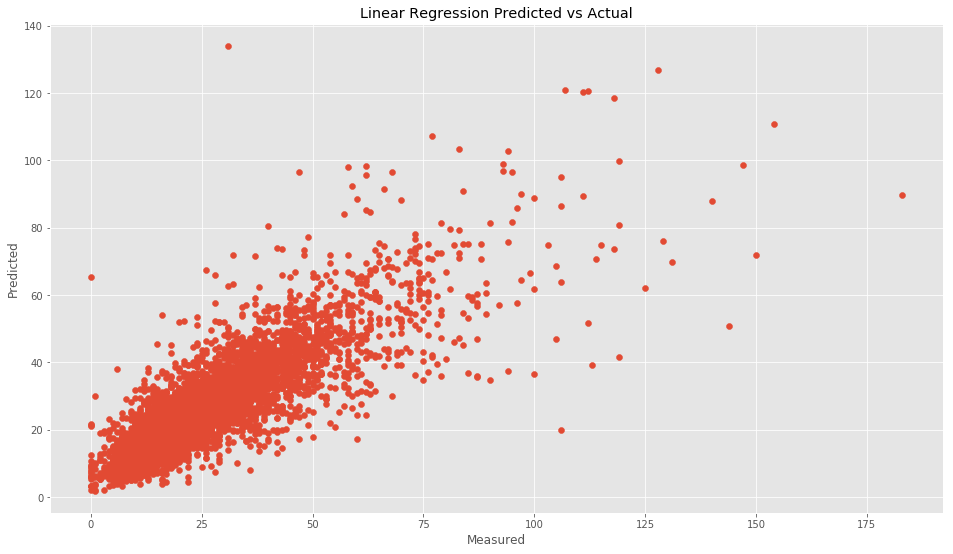

(array([43.09228342, 15.38221248, 26.01963831, ...,  8.08807878,
        27.01277023, 42.47385759]), 0.7100145976235479)

In [62]:
LRModel(X_Train,Y_Train,X_Test,Y_Test)

#### Multi-Layer Perceptron Regressor
MLP as the second model

In [63]:
def MLPModel(x_train,y_train,x_test,y_test):
    ##
    ##
    ##
    ## MLPRegressor
    aqModelMLP = MLPRegressor()
    ## Train Model
    aqModelMLP.fit(x_train, y_train)
    ## Predict
    aqModelMLPPredict = aqModelMLP.predict(x_test)
    ## Scoring the model
    aqMLPNNScore = aqModelMLP.score(x_test,y_test)
    
    ModelErrors(y_test,aqModelMLPPredict)
    
    
    ## Visualise
    title = 'Neural Network Regression Predicted vs Actual'
    VisualiseModel(y_test, aqModelMLPPredict, title)
    
    return aqModelMLPPredict, aqMLPNNScore

-------------------------------------------------
|	RMSE	|	MAE	|	R^2	|
-------------------------------------------------

|	1.43e+02	|	9.66	|	0.484	|
-------------------------------------------------


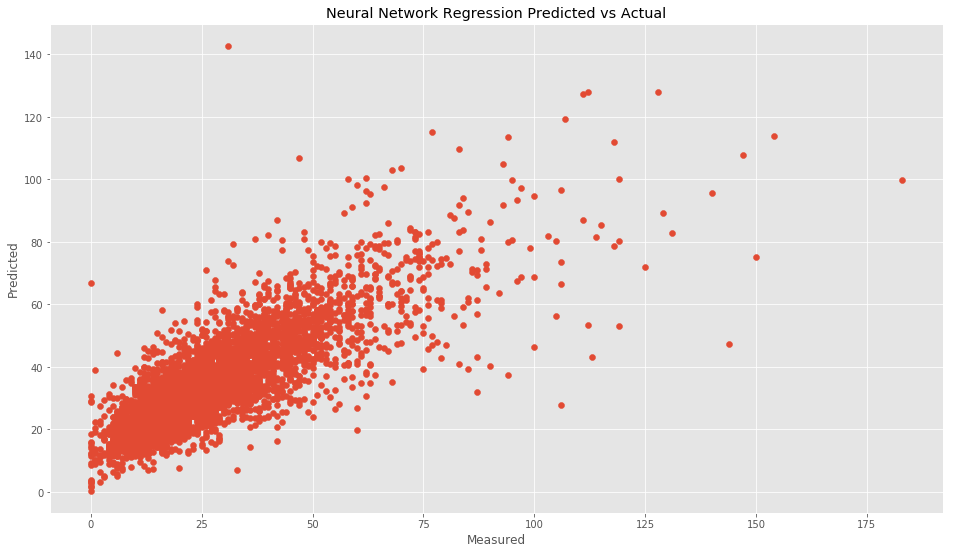

(array([53.91681761, 24.87029202, 33.57682095, ..., 17.10749143,
        38.44992039, 44.43107371]), 0.483984882446439)

In [64]:
MLPModel(X_Train,Y_Train,X_Test,Y_Test)

#### Lasso
Lasso Model

In [65]:
def LassoModel(x_train,y_train,x_test,y_test):
    ##
    ##
    ##
    ## Lasso
    aqModelLasso = Lasso()
    ## Train Model
    aqModelLasso.fit(x_train, y_train)
    ## Predict
    aqModelLassoPredict = aqModelLasso.predict(x_test)
    ## Scoring the model
    aqLassoScore = aqModelLasso.score(x_test,y_test)
    
    ModelErrors(y_test,aqModelLassoPredict)
 
    ## Visualise
    title = 'Lasso Predicted vs Actual'
    VisualiseModel(y_test,aqModelLassoPredict,title)

    return aqModelLassoPredict, aqLassoScore

-------------------------------------------------
|	RMSE	|	MAE	|	R^2	|
-------------------------------------------------

|	84.1	|	5.66	|	0.696	|
-------------------------------------------------


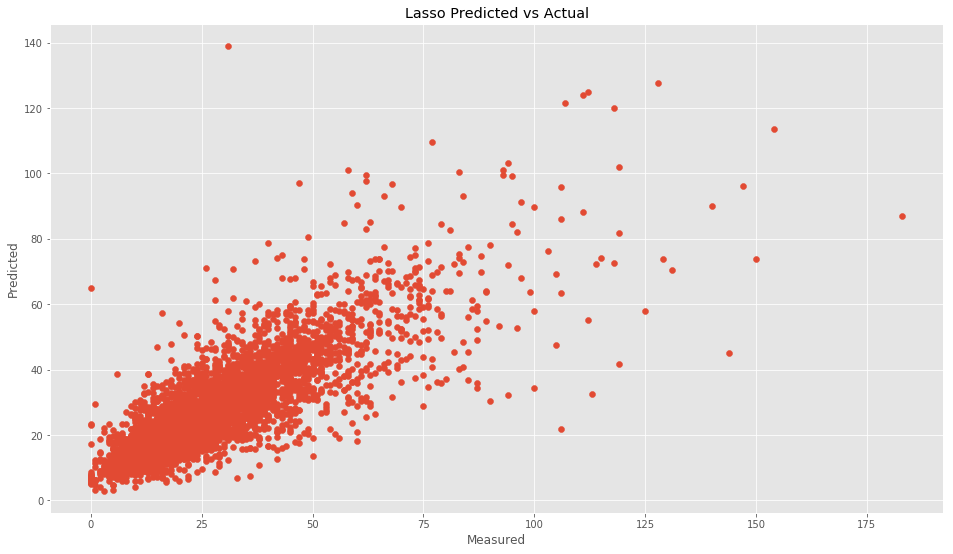

(array([46.78780018, 17.33486642, 28.21251335, ...,  5.78161341,
        28.71770446, 42.11863441]), 0.695753474416268)

In [66]:
LassoModel(X_Train,Y_Train,X_Test,Y_Test)

#### Random Forest Regressor
Random Forest Regressor Model

In [67]:
def RFRModel(x_train,y_train,x_test,y_test):
    ##
    ##
    ##
    ## Random Forest Regressor
    aqModelRFR = RandomForestRegressor(n_estimators=300,random_state=1234)
    ## Train Model
    aqModelRFR.fit(x_train, y_train)
    ## Predict
    aqModelRFRPredict = aqModelRFR.predict(x_test)
    ## Scoring the model
    aqRFRScore = aqModelRFR.score(x_test,y_test)
    
    ModelErrors(y_test,aqModelRFRPredict)
    
     ## Visualise
    title = 'Random Forest Predicted vs Actual'
    VisualiseModel(y_test,aqModelRFRPredict,title)   
    
    return aqModelRFRPredict, aqRFRScore

-------------------------------------------------
|	RMSE	|	MAE	|	R^2	|
-------------------------------------------------

|	84.5	|	5.52	|	0.694	|
-------------------------------------------------


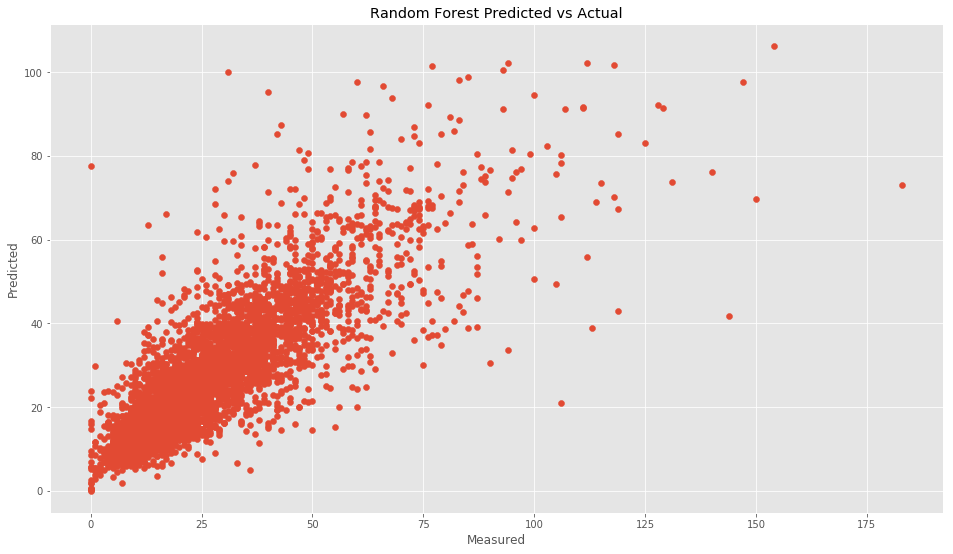

(array([45.77      , 15.53333333, 29.6       , ..., 10.37666667,
        31.        , 46.97333333]), 0.6942686777980358)

In [68]:
RFRModel(X_Train,Y_Train,X_Test,Y_Test)

In [69]:
#features = X.columns
#imp = aqModelRFR.feature_importances_
#indx = np.argsort(imp)

#plt.title('Feature Importances')
#plt.barh(range(len(indx)), imp[indx], color='g', align='center')
#plt.yticks(range(len(indx)),features[indx])
#plt.xlabel('Relative Importance')
#plt.show()

NameError: name 'aqModelRFR' is not defined